## Dependencies Installed

In [ ]:
#!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib seaborn tensorboard

## 1. Import and Install Dependencies

In [57]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam
from scipy import stats

# 2. Keypoints using MP Holistic

In [58]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [59]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [60]:
def draw_styled_landmarks(image, results):
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                                  mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                                  mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2))
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2))
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

## 3. Extract Keypoints with Normalization (Excluding Face Landmarks)

In [61]:
def normalize_keypoints(keypoints, frame_width=640, frame_height=480):
    keypoints[0::4] /= frame_width  # Normalize x
    keypoints[1::4] /= frame_height  # Normalize y
    return keypoints

In [62]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.full(132, -1)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.full(63, -1)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.full(63, -1)
    keypoints = np.concatenate([pose, lh, rh])
    keypoints = normalize_keypoints(keypoints)
    return keypoints

In [63]:
def augment_keypoints(keypoints, noise_level=0.01):
    noise = np.random.normal(0, noise_level, keypoints.shape)
    return keypoints + noise

## 4. Set Folders for Collection

In [64]:
DATA_PATH = os.path.join('MP_Data')
actions = np.array(['hello', 'Good game', 'Loser'])
no_sequences = 30
sequence_length = 30

In [65]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

## 5. Collect Keypoint Values for Training and Testing

In [66]:
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences):
            collected_frames = 0
            frame_num = 0
            while collected_frames < sequence_length:
                ret, frame = cap.read()
                if not ret:
                    print("Failed to capture frame.")
                    break

                image, results = mediapipe_detection(frame, holistic)
                draw_styled_landmarks(image, results)

                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)

                keypoints = extract_keypoints(results)
                if -1 in keypoints:
                    print(f"Missing landmarks in frame {frame_num} for {action} sequence {sequence}. Retrying...")
                    frame_num += 1
                    continue

                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(collected_frames))
                print(f"Saving to {npy_path}.npy")
                np.save(npy_path, keypoints)
                collected_frames += 1
                frame_num += 1

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
            if collected_frames < sequence_length:
                print(f"Failed to collect enough frames for {action} sequence {sequence}. Collected {collected_frames}/{sequence_length} frames.")
cap.release()
cv2.destroyAllWindows()

Missing landmarks in frame 0 for hello sequence 0. Retrying...
Missing landmarks in frame 1 for hello sequence 0. Retrying...
Missing landmarks in frame 2 for hello sequence 0. Retrying...
Missing landmarks in frame 3 for hello sequence 0. Retrying...
Missing landmarks in frame 4 for hello sequence 0. Retrying...
Missing landmarks in frame 5 for hello sequence 0. Retrying...
Missing landmarks in frame 6 for hello sequence 0. Retrying...
Missing landmarks in frame 7 for hello sequence 0. Retrying...
Missing landmarks in frame 8 for hello sequence 0. Retrying...
Missing landmarks in frame 9 for hello sequence 0. Retrying...
Missing landmarks in frame 10 for hello sequence 0. Retrying...
Missing landmarks in frame 11 for hello sequence 0. Retrying...
Missing landmarks in frame 12 for hello sequence 0. Retrying...
Missing landmarks in frame 13 for hello sequence 0. Retrying...
Missing landmarks in frame 14 for hello sequence 0. Retrying...
Missing landmarks in frame 15 for hello sequence 0

Saving to MP_Data\hello\5\27.npy
Saving to MP_Data\hello\5\28.npy
Saving to MP_Data\hello\5\29.npy
Saving to MP_Data\hello\6\0.npy
Saving to MP_Data\hello\6\1.npy
Saving to MP_Data\hello\6\2.npy
Saving to MP_Data\hello\6\3.npy
Saving to MP_Data\hello\6\4.npy
Saving to MP_Data\hello\6\5.npy
Saving to MP_Data\hello\6\6.npy
Saving to MP_Data\hello\6\7.npy
Saving to MP_Data\hello\6\8.npy
Saving to MP_Data\hello\6\9.npy
Saving to MP_Data\hello\6\10.npy
Saving to MP_Data\hello\6\11.npy
Saving to MP_Data\hello\6\12.npy
Saving to MP_Data\hello\6\13.npy
Saving to MP_Data\hello\6\14.npy
Saving to MP_Data\hello\6\15.npy
Saving to MP_Data\hello\6\16.npy
Saving to MP_Data\hello\6\17.npy
Saving to MP_Data\hello\6\18.npy
Saving to MP_Data\hello\6\19.npy
Saving to MP_Data\hello\6\20.npy
Saving to MP_Data\hello\6\21.npy
Saving to MP_Data\hello\6\22.npy
Saving to MP_Data\hello\6\23.npy
Saving to MP_Data\hello\6\24.npy
Saving to MP_Data\hello\6\25.npy
Saving to MP_Data\hello\6\26.npy
Saving to MP_Data\he

Missing landmarks in frame 68 for hello sequence 10. Retrying...
Missing landmarks in frame 69 for hello sequence 10. Retrying...
Missing landmarks in frame 70 for hello sequence 10. Retrying...
Missing landmarks in frame 71 for hello sequence 10. Retrying...
Missing landmarks in frame 72 for hello sequence 10. Retrying...
Missing landmarks in frame 73 for hello sequence 10. Retrying...
Missing landmarks in frame 74 for hello sequence 10. Retrying...
Missing landmarks in frame 75 for hello sequence 10. Retrying...
Missing landmarks in frame 76 for hello sequence 10. Retrying...
Missing landmarks in frame 77 for hello sequence 10. Retrying...
Missing landmarks in frame 78 for hello sequence 10. Retrying...
Missing landmarks in frame 79 for hello sequence 10. Retrying...
Missing landmarks in frame 80 for hello sequence 10. Retrying...
Missing landmarks in frame 81 for hello sequence 10. Retrying...
Missing landmarks in frame 82 for hello sequence 10. Retrying...
Missing landmarks in fram

Missing landmarks in frame 197 for hello sequence 10. Retrying...
Missing landmarks in frame 198 for hello sequence 10. Retrying...
Missing landmarks in frame 199 for hello sequence 10. Retrying...
Missing landmarks in frame 200 for hello sequence 10. Retrying...
Missing landmarks in frame 201 for hello sequence 10. Retrying...
Missing landmarks in frame 202 for hello sequence 10. Retrying...
Missing landmarks in frame 203 for hello sequence 10. Retrying...
Missing landmarks in frame 204 for hello sequence 10. Retrying...
Missing landmarks in frame 205 for hello sequence 10. Retrying...
Missing landmarks in frame 206 for hello sequence 10. Retrying...
Missing landmarks in frame 207 for hello sequence 10. Retrying...
Missing landmarks in frame 208 for hello sequence 10. Retrying...
Missing landmarks in frame 209 for hello sequence 10. Retrying...
Missing landmarks in frame 210 for hello sequence 10. Retrying...
Missing landmarks in frame 211 for hello sequence 10. Retrying...
Missing la

Missing landmarks in frame 324 for hello sequence 10. Retrying...
Missing landmarks in frame 325 for hello sequence 10. Retrying...
Missing landmarks in frame 326 for hello sequence 10. Retrying...
Missing landmarks in frame 327 for hello sequence 10. Retrying...
Missing landmarks in frame 328 for hello sequence 10. Retrying...
Missing landmarks in frame 329 for hello sequence 10. Retrying...
Missing landmarks in frame 330 for hello sequence 10. Retrying...
Missing landmarks in frame 331 for hello sequence 10. Retrying...
Missing landmarks in frame 332 for hello sequence 10. Retrying...
Missing landmarks in frame 333 for hello sequence 10. Retrying...
Missing landmarks in frame 334 for hello sequence 10. Retrying...
Missing landmarks in frame 335 for hello sequence 10. Retrying...
Missing landmarks in frame 336 for hello sequence 10. Retrying...
Missing landmarks in frame 337 for hello sequence 10. Retrying...
Missing landmarks in frame 338 for hello sequence 10. Retrying...
Missing la

Missing landmarks in frame 453 for hello sequence 10. Retrying...
Missing landmarks in frame 454 for hello sequence 10. Retrying...
Missing landmarks in frame 455 for hello sequence 10. Retrying...
Missing landmarks in frame 456 for hello sequence 10. Retrying...
Missing landmarks in frame 457 for hello sequence 10. Retrying...
Missing landmarks in frame 458 for hello sequence 10. Retrying...
Missing landmarks in frame 459 for hello sequence 10. Retrying...
Missing landmarks in frame 460 for hello sequence 10. Retrying...
Missing landmarks in frame 461 for hello sequence 10. Retrying...
Missing landmarks in frame 462 for hello sequence 10. Retrying...
Missing landmarks in frame 463 for hello sequence 10. Retrying...
Missing landmarks in frame 464 for hello sequence 10. Retrying...
Missing landmarks in frame 465 for hello sequence 10. Retrying...
Missing landmarks in frame 466 for hello sequence 10. Retrying...
Missing landmarks in frame 467 for hello sequence 10. Retrying...
Missing la

Missing landmarks in frame 27 for hello sequence 13. Retrying...
Missing landmarks in frame 28 for hello sequence 13. Retrying...
Missing landmarks in frame 29 for hello sequence 13. Retrying...
Missing landmarks in frame 30 for hello sequence 13. Retrying...
Missing landmarks in frame 31 for hello sequence 13. Retrying...
Missing landmarks in frame 32 for hello sequence 13. Retrying...
Missing landmarks in frame 33 for hello sequence 13. Retrying...
Missing landmarks in frame 34 for hello sequence 13. Retrying...
Missing landmarks in frame 35 for hello sequence 13. Retrying...
Missing landmarks in frame 36 for hello sequence 13. Retrying...
Missing landmarks in frame 37 for hello sequence 13. Retrying...
Missing landmarks in frame 38 for hello sequence 13. Retrying...
Missing landmarks in frame 39 for hello sequence 13. Retrying...
Missing landmarks in frame 40 for hello sequence 13. Retrying...
Missing landmarks in frame 41 for hello sequence 13. Retrying...
Missing landmarks in fram

Saving to MP_Data\hello\16\7.npy
Saving to MP_Data\hello\16\8.npy
Saving to MP_Data\hello\16\9.npy
Saving to MP_Data\hello\16\10.npy
Saving to MP_Data\hello\16\11.npy
Saving to MP_Data\hello\16\12.npy
Saving to MP_Data\hello\16\13.npy
Saving to MP_Data\hello\16\14.npy
Saving to MP_Data\hello\16\15.npy
Saving to MP_Data\hello\16\16.npy
Saving to MP_Data\hello\16\17.npy
Saving to MP_Data\hello\16\18.npy
Saving to MP_Data\hello\16\19.npy
Saving to MP_Data\hello\16\20.npy
Saving to MP_Data\hello\16\21.npy
Saving to MP_Data\hello\16\22.npy
Saving to MP_Data\hello\16\23.npy
Saving to MP_Data\hello\16\24.npy
Saving to MP_Data\hello\16\25.npy
Saving to MP_Data\hello\16\26.npy
Saving to MP_Data\hello\16\27.npy
Saving to MP_Data\hello\16\28.npy
Saving to MP_Data\hello\16\29.npy
Saving to MP_Data\hello\17\0.npy
Saving to MP_Data\hello\17\1.npy
Saving to MP_Data\hello\17\2.npy
Saving to MP_Data\hello\17\3.npy
Saving to MP_Data\hello\17\4.npy
Saving to MP_Data\hello\17\5.npy
Saving to MP_Data\hello

Saving to MP_Data\hello\24\12.npy
Saving to MP_Data\hello\24\13.npy
Saving to MP_Data\hello\24\14.npy
Saving to MP_Data\hello\24\15.npy
Saving to MP_Data\hello\24\16.npy
Saving to MP_Data\hello\24\17.npy
Saving to MP_Data\hello\24\18.npy
Saving to MP_Data\hello\24\19.npy
Saving to MP_Data\hello\24\20.npy
Saving to MP_Data\hello\24\21.npy
Saving to MP_Data\hello\24\22.npy
Saving to MP_Data\hello\24\23.npy
Saving to MP_Data\hello\24\24.npy
Saving to MP_Data\hello\24\25.npy
Saving to MP_Data\hello\24\26.npy
Saving to MP_Data\hello\24\27.npy
Saving to MP_Data\hello\24\28.npy
Saving to MP_Data\hello\24\29.npy
Saving to MP_Data\hello\25\0.npy
Saving to MP_Data\hello\25\1.npy
Saving to MP_Data\hello\25\2.npy
Saving to MP_Data\hello\25\3.npy
Saving to MP_Data\hello\25\4.npy
Saving to MP_Data\hello\25\5.npy
Saving to MP_Data\hello\25\6.npy
Saving to MP_Data\hello\25\7.npy
Saving to MP_Data\hello\25\8.npy
Saving to MP_Data\hello\25\9.npy
Saving to MP_Data\hello\25\10.npy
Saving to MP_Data\hello\

Missing landmarks in frame 39 for Good game sequence 0. Retrying...
Missing landmarks in frame 40 for Good game sequence 0. Retrying...
Missing landmarks in frame 41 for Good game sequence 0. Retrying...
Missing landmarks in frame 42 for Good game sequence 0. Retrying...
Missing landmarks in frame 43 for Good game sequence 0. Retrying...
Missing landmarks in frame 44 for Good game sequence 0. Retrying...
Missing landmarks in frame 45 for Good game sequence 0. Retrying...
Missing landmarks in frame 46 for Good game sequence 0. Retrying...
Missing landmarks in frame 47 for Good game sequence 0. Retrying...
Missing landmarks in frame 48 for Good game sequence 0. Retrying...
Missing landmarks in frame 49 for Good game sequence 0. Retrying...
Missing landmarks in frame 50 for Good game sequence 0. Retrying...
Missing landmarks in frame 51 for Good game sequence 0. Retrying...
Missing landmarks in frame 52 for Good game sequence 0. Retrying...
Missing landmarks in frame 53 for Good game sequ

Saving to MP_Data\Good game\6\4.npy
Saving to MP_Data\Good game\6\5.npy
Saving to MP_Data\Good game\6\6.npy
Saving to MP_Data\Good game\6\7.npy
Saving to MP_Data\Good game\6\8.npy
Saving to MP_Data\Good game\6\9.npy
Saving to MP_Data\Good game\6\10.npy
Saving to MP_Data\Good game\6\11.npy
Saving to MP_Data\Good game\6\12.npy
Saving to MP_Data\Good game\6\13.npy
Saving to MP_Data\Good game\6\14.npy
Saving to MP_Data\Good game\6\15.npy
Saving to MP_Data\Good game\6\16.npy
Saving to MP_Data\Good game\6\17.npy
Saving to MP_Data\Good game\6\18.npy
Saving to MP_Data\Good game\6\19.npy
Saving to MP_Data\Good game\6\20.npy
Saving to MP_Data\Good game\6\21.npy
Saving to MP_Data\Good game\6\22.npy
Saving to MP_Data\Good game\6\23.npy
Saving to MP_Data\Good game\6\24.npy
Saving to MP_Data\Good game\6\25.npy
Saving to MP_Data\Good game\6\26.npy
Saving to MP_Data\Good game\6\27.npy
Saving to MP_Data\Good game\6\28.npy
Saving to MP_Data\Good game\6\29.npy
Saving to MP_Data\Good game\7\0.npy
Saving t

Saving to MP_Data\Good game\13\17.npy
Saving to MP_Data\Good game\13\18.npy
Saving to MP_Data\Good game\13\19.npy
Saving to MP_Data\Good game\13\20.npy
Saving to MP_Data\Good game\13\21.npy
Saving to MP_Data\Good game\13\22.npy
Saving to MP_Data\Good game\13\23.npy
Saving to MP_Data\Good game\13\24.npy
Saving to MP_Data\Good game\13\25.npy
Saving to MP_Data\Good game\13\26.npy
Saving to MP_Data\Good game\13\27.npy
Saving to MP_Data\Good game\13\28.npy
Saving to MP_Data\Good game\13\29.npy
Saving to MP_Data\Good game\14\0.npy
Saving to MP_Data\Good game\14\1.npy
Saving to MP_Data\Good game\14\2.npy
Saving to MP_Data\Good game\14\3.npy
Saving to MP_Data\Good game\14\4.npy
Saving to MP_Data\Good game\14\5.npy
Saving to MP_Data\Good game\14\6.npy
Saving to MP_Data\Good game\14\7.npy
Saving to MP_Data\Good game\14\8.npy
Saving to MP_Data\Good game\14\9.npy
Saving to MP_Data\Good game\14\10.npy
Saving to MP_Data\Good game\14\11.npy
Saving to MP_Data\Good game\14\12.npy
Saving to MP_Data\Good

Missing landmarks in frame 31 for Good game sequence 16. Retrying...
Missing landmarks in frame 32 for Good game sequence 16. Retrying...
Missing landmarks in frame 33 for Good game sequence 16. Retrying...
Missing landmarks in frame 34 for Good game sequence 16. Retrying...
Missing landmarks in frame 35 for Good game sequence 16. Retrying...
Saving to MP_Data\Good game\16\17.npy
Saving to MP_Data\Good game\16\18.npy
Saving to MP_Data\Good game\16\19.npy
Saving to MP_Data\Good game\16\20.npy
Missing landmarks in frame 40 for Good game sequence 16. Retrying...
Missing landmarks in frame 41 for Good game sequence 16. Retrying...
Missing landmarks in frame 42 for Good game sequence 16. Retrying...
Missing landmarks in frame 43 for Good game sequence 16. Retrying...
Missing landmarks in frame 44 for Good game sequence 16. Retrying...
Missing landmarks in frame 45 for Good game sequence 16. Retrying...
Missing landmarks in frame 46 for Good game sequence 16. Retrying...
Missing landmarks in

Missing landmarks in frame 108 for Good game sequence 17. Retrying...
Missing landmarks in frame 109 for Good game sequence 17. Retrying...
Missing landmarks in frame 110 for Good game sequence 17. Retrying...
Missing landmarks in frame 111 for Good game sequence 17. Retrying...
Missing landmarks in frame 112 for Good game sequence 17. Retrying...
Saving to MP_Data\Good game\17\27.npy
Saving to MP_Data\Good game\17\28.npy
Missing landmarks in frame 115 for Good game sequence 17. Retrying...
Missing landmarks in frame 116 for Good game sequence 17. Retrying...
Missing landmarks in frame 117 for Good game sequence 17. Retrying...
Missing landmarks in frame 118 for Good game sequence 17. Retrying...
Missing landmarks in frame 119 for Good game sequence 17. Retrying...
Missing landmarks in frame 120 for Good game sequence 17. Retrying...
Missing landmarks in frame 121 for Good game sequence 17. Retrying...
Saving to MP_Data\Good game\17\29.npy
Saving to MP_Data\Good game\18\0.npy
Saving to

Saving to MP_Data\Good game\21\17.npy
Saving to MP_Data\Good game\21\18.npy
Saving to MP_Data\Good game\21\19.npy
Saving to MP_Data\Good game\21\20.npy
Saving to MP_Data\Good game\21\21.npy
Saving to MP_Data\Good game\21\22.npy
Saving to MP_Data\Good game\21\23.npy
Saving to MP_Data\Good game\21\24.npy
Saving to MP_Data\Good game\21\25.npy
Saving to MP_Data\Good game\21\26.npy
Saving to MP_Data\Good game\21\27.npy
Saving to MP_Data\Good game\21\28.npy
Saving to MP_Data\Good game\21\29.npy
Saving to MP_Data\Good game\22\0.npy
Saving to MP_Data\Good game\22\1.npy
Saving to MP_Data\Good game\22\2.npy
Saving to MP_Data\Good game\22\3.npy
Saving to MP_Data\Good game\22\4.npy
Saving to MP_Data\Good game\22\5.npy
Saving to MP_Data\Good game\22\6.npy
Saving to MP_Data\Good game\22\7.npy
Saving to MP_Data\Good game\22\8.npy
Saving to MP_Data\Good game\22\9.npy
Saving to MP_Data\Good game\22\10.npy
Saving to MP_Data\Good game\22\11.npy
Saving to MP_Data\Good game\22\12.npy
Saving to MP_Data\Good

Saving to MP_Data\Good game\26\22.npy
Saving to MP_Data\Good game\26\23.npy
Saving to MP_Data\Good game\26\24.npy
Saving to MP_Data\Good game\26\25.npy
Saving to MP_Data\Good game\26\26.npy
Saving to MP_Data\Good game\26\27.npy
Saving to MP_Data\Good game\26\28.npy
Saving to MP_Data\Good game\26\29.npy
Saving to MP_Data\Good game\27\0.npy
Saving to MP_Data\Good game\27\1.npy
Saving to MP_Data\Good game\27\2.npy
Saving to MP_Data\Good game\27\3.npy
Saving to MP_Data\Good game\27\4.npy
Missing landmarks in frame 5 for Good game sequence 27. Retrying...
Saving to MP_Data\Good game\27\5.npy
Saving to MP_Data\Good game\27\6.npy
Saving to MP_Data\Good game\27\7.npy
Saving to MP_Data\Good game\27\8.npy
Saving to MP_Data\Good game\27\9.npy
Saving to MP_Data\Good game\27\10.npy
Saving to MP_Data\Good game\27\11.npy
Saving to MP_Data\Good game\27\12.npy
Saving to MP_Data\Good game\27\13.npy
Saving to MP_Data\Good game\27\14.npy
Saving to MP_Data\Good game\27\15.npy
Saving to MP_Data\Good game\27

Saving to MP_Data\Loser\3\4.npy
Saving to MP_Data\Loser\3\5.npy
Saving to MP_Data\Loser\3\6.npy
Saving to MP_Data\Loser\3\7.npy
Saving to MP_Data\Loser\3\8.npy
Saving to MP_Data\Loser\3\9.npy
Saving to MP_Data\Loser\3\10.npy
Saving to MP_Data\Loser\3\11.npy
Saving to MP_Data\Loser\3\12.npy
Saving to MP_Data\Loser\3\13.npy
Saving to MP_Data\Loser\3\14.npy
Saving to MP_Data\Loser\3\15.npy
Saving to MP_Data\Loser\3\16.npy
Saving to MP_Data\Loser\3\17.npy
Saving to MP_Data\Loser\3\18.npy
Saving to MP_Data\Loser\3\19.npy
Saving to MP_Data\Loser\3\20.npy
Saving to MP_Data\Loser\3\21.npy
Saving to MP_Data\Loser\3\22.npy
Saving to MP_Data\Loser\3\23.npy
Saving to MP_Data\Loser\3\24.npy
Saving to MP_Data\Loser\3\25.npy
Saving to MP_Data\Loser\3\26.npy
Saving to MP_Data\Loser\3\27.npy
Saving to MP_Data\Loser\3\28.npy
Saving to MP_Data\Loser\3\29.npy
Saving to MP_Data\Loser\4\0.npy
Saving to MP_Data\Loser\4\1.npy
Saving to MP_Data\Loser\4\2.npy
Saving to MP_Data\Loser\4\3.npy
Saving to MP_Data\Lo

Saving to MP_Data\Loser\11\14.npy
Saving to MP_Data\Loser\11\15.npy
Saving to MP_Data\Loser\11\16.npy
Saving to MP_Data\Loser\11\17.npy
Saving to MP_Data\Loser\11\18.npy
Saving to MP_Data\Loser\11\19.npy
Saving to MP_Data\Loser\11\20.npy
Saving to MP_Data\Loser\11\21.npy
Saving to MP_Data\Loser\11\22.npy
Saving to MP_Data\Loser\11\23.npy
Saving to MP_Data\Loser\11\24.npy
Saving to MP_Data\Loser\11\25.npy
Saving to MP_Data\Loser\11\26.npy
Saving to MP_Data\Loser\11\27.npy
Saving to MP_Data\Loser\11\28.npy
Saving to MP_Data\Loser\11\29.npy
Saving to MP_Data\Loser\12\0.npy
Saving to MP_Data\Loser\12\1.npy
Saving to MP_Data\Loser\12\2.npy
Saving to MP_Data\Loser\12\3.npy
Saving to MP_Data\Loser\12\4.npy
Saving to MP_Data\Loser\12\5.npy
Saving to MP_Data\Loser\12\6.npy
Missing landmarks in frame 7 for Loser sequence 12. Retrying...
Saving to MP_Data\Loser\12\7.npy
Saving to MP_Data\Loser\12\8.npy
Saving to MP_Data\Loser\12\9.npy
Saving to MP_Data\Loser\12\10.npy
Saving to MP_Data\Loser\12\1

Saving to MP_Data\Loser\19\17.npy
Saving to MP_Data\Loser\19\18.npy
Saving to MP_Data\Loser\19\19.npy
Saving to MP_Data\Loser\19\20.npy
Saving to MP_Data\Loser\19\21.npy
Saving to MP_Data\Loser\19\22.npy
Saving to MP_Data\Loser\19\23.npy
Saving to MP_Data\Loser\19\24.npy
Saving to MP_Data\Loser\19\25.npy
Saving to MP_Data\Loser\19\26.npy
Saving to MP_Data\Loser\19\27.npy
Saving to MP_Data\Loser\19\28.npy
Saving to MP_Data\Loser\19\29.npy
Saving to MP_Data\Loser\20\0.npy
Saving to MP_Data\Loser\20\1.npy
Saving to MP_Data\Loser\20\2.npy
Saving to MP_Data\Loser\20\3.npy
Saving to MP_Data\Loser\20\4.npy
Saving to MP_Data\Loser\20\5.npy
Saving to MP_Data\Loser\20\6.npy
Saving to MP_Data\Loser\20\7.npy
Saving to MP_Data\Loser\20\8.npy
Saving to MP_Data\Loser\20\9.npy
Saving to MP_Data\Loser\20\10.npy
Saving to MP_Data\Loser\20\11.npy
Saving to MP_Data\Loser\20\12.npy
Saving to MP_Data\Loser\20\13.npy
Saving to MP_Data\Loser\20\14.npy
Saving to MP_Data\Loser\20\15.npy
Saving to MP_Data\Loser\

Saving to MP_Data\Loser\27\22.npy
Saving to MP_Data\Loser\27\23.npy
Saving to MP_Data\Loser\27\24.npy
Saving to MP_Data\Loser\27\25.npy
Saving to MP_Data\Loser\27\26.npy
Saving to MP_Data\Loser\27\27.npy
Saving to MP_Data\Loser\27\28.npy
Saving to MP_Data\Loser\27\29.npy
Saving to MP_Data\Loser\28\0.npy
Saving to MP_Data\Loser\28\1.npy
Saving to MP_Data\Loser\28\2.npy
Saving to MP_Data\Loser\28\3.npy
Saving to MP_Data\Loser\28\4.npy
Saving to MP_Data\Loser\28\5.npy
Saving to MP_Data\Loser\28\6.npy
Saving to MP_Data\Loser\28\7.npy
Saving to MP_Data\Loser\28\8.npy
Saving to MP_Data\Loser\28\9.npy
Saving to MP_Data\Loser\28\10.npy
Saving to MP_Data\Loser\28\11.npy
Saving to MP_Data\Loser\28\12.npy
Saving to MP_Data\Loser\28\13.npy
Saving to MP_Data\Loser\28\14.npy
Saving to MP_Data\Loser\28\15.npy
Saving to MP_Data\Loser\28\16.npy
Saving to MP_Data\Loser\28\17.npy
Saving to MP_Data\Loser\28\18.npy
Saving to MP_Data\Loser\28\19.npy
Saving to MP_Data\Loser\28\20.npy
Saving to MP_Data\Loser\

## 6. Preprocess Data and Create Labels and Features

In [67]:
label_map = {label: num for num, label in enumerate(actions)}
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        try:
            for frame_num in range(sequence_length):
                file_path = os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy")
                if not os.path.exists(file_path):
                    print(f"File missing: {file_path}. Skipping sequence {sequence} for {action}.")
                    break
                res = np.load(file_path)
                if -1 in res:
                    print(f"Missing landmarks in {file_path}. Skipping sequence {sequence} for {action}.")
                    break
                res = augment_keypoints(res)
                window.append(res)
            if len(window) == sequence_length:
                sequences.append(window)
                labels.append(label_map[action])
            else:
                print(f"Incomplete sequence {sequence} for {action}. Collected {len(window)}/{sequence_length} frames.")
        except FileNotFoundError as e:
            print(f"Error loading sequence {sequence} for {action}: {e}")
            continue
X = np.array(sequences)
y = to_categorical(labels).astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (90, 30, 258)
y shape: (90, 3)


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 7. Build and Train Simpler Model

In [70]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

In [71]:
model = Sequential()
model.add(LSTM(32, return_sequences=False, activation='relu', input_shape=(30, 258)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(actions.shape[0], activation='softmax'))

In [72]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [73]:
model.fit(X_train, y_train, epochs=2000, validation_split=0.2, callbacks=[tb_callback, early_stopping])

Epoch 1/2000
2/2 [==============================] - 1s 206ms/step - loss: 1.1640 - categorical_accuracy: 0.3158 - val_loss: 1.2332 - val_categorical_accuracy: 0.1333
Epoch 2/2000
2/2 [==============================] - 0s 98ms/step - loss: 1.2580 - categorical_accuracy: 0.1930 - val_loss: 1.2327 - val_categorical_accuracy: 0.1333
Epoch 3/2000
2/2 [==============================] - 0s 79ms/step - loss: 1.1963 - categorical_accuracy: 0.3333 - val_loss: 1.2319 - val_categorical_accuracy: 0.1333
Epoch 4/2000
2/2 [==============================] - 0s 84ms/step - loss: 1.2737 - categorical_accuracy: 0.2105 - val_loss: 1.2310 - val_categorical_accuracy: 0.1333
Epoch 5/2000
2/2 [==============================] - 0s 89ms/step - loss: 1.2702 - categorical_accuracy: 0.2456 - val_loss: 1.2300 - val_categorical_accuracy: 0.1333
Epoch 6/2000
2/2 [==============================] - 0s 93ms/step - loss: 1.1893 - categorical_accuracy: 0.2632 - val_loss: 1.2291 - val_categorical_accuracy: 0.1333
Epoch 7/2

2/2 [==============================] - 0s 75ms/step - loss: 1.1420 - categorical_accuracy: 0.3158 - val_loss: 1.2063 - val_categorical_accuracy: 0.2000
Epoch 51/2000
2/2 [==============================] - 0s 73ms/step - loss: 1.1516 - categorical_accuracy: 0.3333 - val_loss: 1.2060 - val_categorical_accuracy: 0.2000
Epoch 52/2000
2/2 [==============================] - 0s 83ms/step - loss: 1.1611 - categorical_accuracy: 0.4035 - val_loss: 1.2057 - val_categorical_accuracy: 0.2000
Epoch 53/2000
2/2 [==============================] - 0s 86ms/step - loss: 1.2281 - categorical_accuracy: 0.1228 - val_loss: 1.2054 - val_categorical_accuracy: 0.2000
Epoch 54/2000
2/2 [==============================] - 0s 70ms/step - loss: 1.0926 - categorical_accuracy: 0.3333 - val_loss: 1.2050 - val_categorical_accuracy: 0.2000
Epoch 55/2000
2/2 [==============================] - 0s 69ms/step - loss: 1.1027 - categorical_accuracy: 0.3333 - val_loss: 1.2048 - val_categorical_accuracy: 0.2000
Epoch 56/2000
2/2 

2/2 [==============================] - 0s 78ms/step - loss: 1.1538 - categorical_accuracy: 0.2982 - val_loss: 1.1936 - val_categorical_accuracy: 0.2000
Epoch 100/2000
2/2 [==============================] - 0s 84ms/step - loss: 1.1267 - categorical_accuracy: 0.3860 - val_loss: 1.1934 - val_categorical_accuracy: 0.2000
Epoch 101/2000
2/2 [==============================] - 0s 96ms/step - loss: 1.1061 - categorical_accuracy: 0.3333 - val_loss: 1.1932 - val_categorical_accuracy: 0.2000
Epoch 102/2000
2/2 [==============================] - 0s 78ms/step - loss: 1.1308 - categorical_accuracy: 0.3333 - val_loss: 1.1929 - val_categorical_accuracy: 0.2000
Epoch 103/2000
2/2 [==============================] - 0s 70ms/step - loss: 1.1225 - categorical_accuracy: 0.3333 - val_loss: 1.1926 - val_categorical_accuracy: 0.2000
Epoch 104/2000
2/2 [==============================] - 0s 70ms/step - loss: 1.1290 - categorical_accuracy: 0.3684 - val_loss: 1.1924 - val_categorical_accuracy: 0.2000
Epoch 105/200

2/2 [==============================] - 0s 88ms/step - loss: 1.1031 - categorical_accuracy: 0.3509 - val_loss: 1.1802 - val_categorical_accuracy: 0.2000
Epoch 149/2000
2/2 [==============================] - 0s 65ms/step - loss: 1.1182 - categorical_accuracy: 0.3333 - val_loss: 1.1800 - val_categorical_accuracy: 0.2000
Epoch 150/2000
2/2 [==============================] - 0s 73ms/step - loss: 1.0894 - categorical_accuracy: 0.3509 - val_loss: 1.1797 - val_categorical_accuracy: 0.2000
Epoch 151/2000
2/2 [==============================] - 0s 69ms/step - loss: 1.0647 - categorical_accuracy: 0.3860 - val_loss: 1.1794 - val_categorical_accuracy: 0.2000
Epoch 152/2000
2/2 [==============================] - 0s 75ms/step - loss: 1.1257 - categorical_accuracy: 0.3684 - val_loss: 1.1791 - val_categorical_accuracy: 0.2000
Epoch 153/2000
2/2 [==============================] - 0s 65ms/step - loss: 1.1104 - categorical_accuracy: 0.3333 - val_loss: 1.1787 - val_categorical_accuracy: 0.2000
Epoch 154/200

2/2 [==============================] - 0s 89ms/step - loss: 1.0959 - categorical_accuracy: 0.3860 - val_loss: 1.1672 - val_categorical_accuracy: 0.2000
Epoch 198/2000
2/2 [==============================] - 0s 81ms/step - loss: 1.0517 - categorical_accuracy: 0.4211 - val_loss: 1.1668 - val_categorical_accuracy: 0.2000
Epoch 199/2000
2/2 [==============================] - 0s 77ms/step - loss: 1.0647 - categorical_accuracy: 0.4035 - val_loss: 1.1664 - val_categorical_accuracy: 0.2000
Epoch 200/2000
2/2 [==============================] - 0s 101ms/step - loss: 1.0665 - categorical_accuracy: 0.4035 - val_loss: 1.1661 - val_categorical_accuracy: 0.2000
Epoch 201/2000
2/2 [==============================] - 0s 70ms/step - loss: 1.0391 - categorical_accuracy: 0.4211 - val_loss: 1.1657 - val_categorical_accuracy: 0.2000
Epoch 202/2000
2/2 [==============================] - 0s 69ms/step - loss: 1.0673 - categorical_accuracy: 0.3860 - val_loss: 1.1653 - val_categorical_accuracy: 0.2000
Epoch 203/20

2/2 [==============================] - 0s 80ms/step - loss: 1.0421 - categorical_accuracy: 0.4035 - val_loss: 1.1508 - val_categorical_accuracy: 0.2000
Epoch 247/2000
2/2 [==============================] - 0s 81ms/step - loss: 1.0503 - categorical_accuracy: 0.4211 - val_loss: 1.1506 - val_categorical_accuracy: 0.2000
Epoch 248/2000
2/2 [==============================] - 0s 67ms/step - loss: 1.0512 - categorical_accuracy: 0.3684 - val_loss: 1.1503 - val_categorical_accuracy: 0.2000
Epoch 249/2000
2/2 [==============================] - 0s 67ms/step - loss: 1.1055 - categorical_accuracy: 0.3684 - val_loss: 1.1501 - val_categorical_accuracy: 0.2000
Epoch 250/2000
2/2 [==============================] - 0s 66ms/step - loss: 1.0643 - categorical_accuracy: 0.4035 - val_loss: 1.1498 - val_categorical_accuracy: 0.2000
Epoch 251/2000
2/2 [==============================] - 0s 80ms/step - loss: 0.9918 - categorical_accuracy: 0.4561 - val_loss: 1.1496 - val_categorical_accuracy: 0.2000
Epoch 252/200

2/2 [==============================] - 0s 65ms/step - loss: 1.0114 - categorical_accuracy: 0.3860 - val_loss: 1.1330 - val_categorical_accuracy: 0.2000
Epoch 296/2000
2/2 [==============================] - 0s 70ms/step - loss: 0.9996 - categorical_accuracy: 0.3684 - val_loss: 1.1325 - val_categorical_accuracy: 0.2000
Epoch 297/2000
2/2 [==============================] - 0s 82ms/step - loss: 1.0646 - categorical_accuracy: 0.3684 - val_loss: 1.1319 - val_categorical_accuracy: 0.2000
Epoch 298/2000
2/2 [==============================] - 0s 79ms/step - loss: 1.0412 - categorical_accuracy: 0.3860 - val_loss: 1.1313 - val_categorical_accuracy: 0.2000
Epoch 299/2000
2/2 [==============================] - 0s 69ms/step - loss: 0.9864 - categorical_accuracy: 0.4561 - val_loss: 1.1307 - val_categorical_accuracy: 0.2000
Epoch 300/2000
2/2 [==============================] - 0s 85ms/step - loss: 1.0391 - categorical_accuracy: 0.3860 - val_loss: 1.1300 - val_categorical_accuracy: 0.2000
Epoch 301/200

2/2 [==============================] - 0s 67ms/step - loss: 1.0488 - categorical_accuracy: 0.3509 - val_loss: 1.1011 - val_categorical_accuracy: 0.2000
Epoch 345/2000
2/2 [==============================] - 0s 83ms/step - loss: 0.9312 - categorical_accuracy: 0.5439 - val_loss: 1.1006 - val_categorical_accuracy: 0.2000
Epoch 346/2000
2/2 [==============================] - 0s 83ms/step - loss: 0.9578 - categorical_accuracy: 0.4561 - val_loss: 1.0999 - val_categorical_accuracy: 0.2000
Epoch 347/2000
2/2 [==============================] - 0s 82ms/step - loss: 1.0110 - categorical_accuracy: 0.4737 - val_loss: 1.0991 - val_categorical_accuracy: 0.2000
Epoch 348/2000
2/2 [==============================] - 0s 70ms/step - loss: 0.9609 - categorical_accuracy: 0.5263 - val_loss: 1.0981 - val_categorical_accuracy: 0.2000
Epoch 349/2000
2/2 [==============================] - 0s 84ms/step - loss: 0.9712 - categorical_accuracy: 0.4035 - val_loss: 1.0972 - val_categorical_accuracy: 0.2000
Epoch 350/200

2/2 [==============================] - 0s 69ms/step - loss: 0.9411 - categorical_accuracy: 0.4737 - val_loss: 1.0473 - val_categorical_accuracy: 0.2667
Epoch 394/2000
2/2 [==============================] - 0s 70ms/step - loss: 0.9240 - categorical_accuracy: 0.4912 - val_loss: 1.0459 - val_categorical_accuracy: 0.3333
Epoch 395/2000
2/2 [==============================] - 0s 67ms/step - loss: 0.8924 - categorical_accuracy: 0.5088 - val_loss: 1.0444 - val_categorical_accuracy: 0.3333
Epoch 396/2000
2/2 [==============================] - 0s 80ms/step - loss: 0.9575 - categorical_accuracy: 0.4211 - val_loss: 1.0428 - val_categorical_accuracy: 0.3333
Epoch 397/2000
2/2 [==============================] - 0s 73ms/step - loss: 0.9029 - categorical_accuracy: 0.5439 - val_loss: 1.0413 - val_categorical_accuracy: 0.3333
Epoch 398/2000
2/2 [==============================] - 0s 77ms/step - loss: 0.8787 - categorical_accuracy: 0.5789 - val_loss: 1.0396 - val_categorical_accuracy: 0.4000
Epoch 399/200

2/2 [==============================] - 0s 76ms/step - loss: 0.8846 - categorical_accuracy: 0.4737 - val_loss: 0.9661 - val_categorical_accuracy: 0.6000
Epoch 443/2000
2/2 [==============================] - 0s 69ms/step - loss: 0.8067 - categorical_accuracy: 0.6491 - val_loss: 0.9641 - val_categorical_accuracy: 0.6000
Epoch 444/2000
2/2 [==============================] - 0s 82ms/step - loss: 0.8289 - categorical_accuracy: 0.5789 - val_loss: 0.9618 - val_categorical_accuracy: 0.6000
Epoch 445/2000
2/2 [==============================] - 0s 88ms/step - loss: 0.8276 - categorical_accuracy: 0.5789 - val_loss: 0.9595 - val_categorical_accuracy: 0.6000
Epoch 446/2000
2/2 [==============================] - 0s 80ms/step - loss: 0.8168 - categorical_accuracy: 0.6140 - val_loss: 0.9569 - val_categorical_accuracy: 0.6000
Epoch 447/2000
2/2 [==============================] - 0s 60ms/step - loss: 0.8142 - categorical_accuracy: 0.5789 - val_loss: 0.9542 - val_categorical_accuracy: 0.6000
Epoch 448/200

2/2 [==============================] - 0s 73ms/step - loss: 0.7972 - categorical_accuracy: 0.6316 - val_loss: 0.8278 - val_categorical_accuracy: 0.7333
Epoch 492/2000
2/2 [==============================] - 0s 72ms/step - loss: 0.8207 - categorical_accuracy: 0.6140 - val_loss: 0.8247 - val_categorical_accuracy: 0.7333
Epoch 493/2000
2/2 [==============================] - 0s 72ms/step - loss: 0.7526 - categorical_accuracy: 0.5789 - val_loss: 0.8214 - val_categorical_accuracy: 0.7333
Epoch 494/2000
2/2 [==============================] - 0s 71ms/step - loss: 0.7016 - categorical_accuracy: 0.6667 - val_loss: 0.8179 - val_categorical_accuracy: 0.7333
Epoch 495/2000
2/2 [==============================] - 0s 80ms/step - loss: 0.8125 - categorical_accuracy: 0.5263 - val_loss: 0.8149 - val_categorical_accuracy: 0.7333
Epoch 496/2000
2/2 [==============================] - 0s 77ms/step - loss: 0.7524 - categorical_accuracy: 0.5965 - val_loss: 0.8119 - val_categorical_accuracy: 0.7333
Epoch 497/200

2/2 [==============================] - 0s 78ms/step - loss: 0.7086 - categorical_accuracy: 0.6491 - val_loss: 0.7188 - val_categorical_accuracy: 0.6667
Epoch 541/2000
2/2 [==============================] - 0s 73ms/step - loss: 0.6493 - categorical_accuracy: 0.7193 - val_loss: 0.7173 - val_categorical_accuracy: 0.6667
Epoch 542/2000
2/2 [==============================] - 0s 63ms/step - loss: 0.6998 - categorical_accuracy: 0.6316 - val_loss: 0.7160 - val_categorical_accuracy: 0.6667
Epoch 543/2000
2/2 [==============================] - 0s 79ms/step - loss: 0.7045 - categorical_accuracy: 0.7193 - val_loss: 0.7142 - val_categorical_accuracy: 0.6667
Epoch 544/2000
2/2 [==============================] - 0s 84ms/step - loss: 0.6704 - categorical_accuracy: 0.6667 - val_loss: 0.7124 - val_categorical_accuracy: 0.6667
Epoch 545/2000
2/2 [==============================] - 0s 63ms/step - loss: 0.7425 - categorical_accuracy: 0.6491 - val_loss: 0.7106 - val_categorical_accuracy: 0.6667
Epoch 546/200

2/2 [==============================] - 0s 85ms/step - loss: 0.7216 - categorical_accuracy: 0.6667 - val_loss: 0.6741 - val_categorical_accuracy: 0.6667
Epoch 590/2000
2/2 [==============================] - 0s 67ms/step - loss: 0.5749 - categorical_accuracy: 0.6667 - val_loss: 0.6741 - val_categorical_accuracy: 0.6667
Epoch 591/2000
2/2 [==============================] - 0s 61ms/step - loss: 0.6770 - categorical_accuracy: 0.7368 - val_loss: 0.6740 - val_categorical_accuracy: 0.6667
Epoch 592/2000
2/2 [==============================] - 0s 66ms/step - loss: 0.7420 - categorical_accuracy: 0.6316 - val_loss: 0.6739 - val_categorical_accuracy: 0.6667
Epoch 593/2000
2/2 [==============================] - 0s 63ms/step - loss: 0.5814 - categorical_accuracy: 0.7193 - val_loss: 0.6741 - val_categorical_accuracy: 0.6667
Epoch 594/2000
2/2 [==============================] - 0s 63ms/step - loss: 0.7055 - categorical_accuracy: 0.6316 - val_loss: 0.6742 - val_categorical_accuracy: 0.6667
Epoch 595/200

2/2 [==============================] - 0s 77ms/step - loss: 0.6424 - categorical_accuracy: 0.6842 - val_loss: 0.6536 - val_categorical_accuracy: 0.7333
Epoch 639/2000
2/2 [==============================] - 0s 80ms/step - loss: 0.6393 - categorical_accuracy: 0.6316 - val_loss: 0.6537 - val_categorical_accuracy: 0.7333
Epoch 640/2000
2/2 [==============================] - 0s 70ms/step - loss: 0.5330 - categorical_accuracy: 0.7895 - val_loss: 0.6536 - val_categorical_accuracy: 0.7333
Epoch 641/2000
2/2 [==============================] - 0s 75ms/step - loss: 0.5467 - categorical_accuracy: 0.7895 - val_loss: 0.6531 - val_categorical_accuracy: 0.7333
Epoch 642/2000
2/2 [==============================] - 0s 61ms/step - loss: 0.6659 - categorical_accuracy: 0.7018 - val_loss: 0.6525 - val_categorical_accuracy: 0.7333
Epoch 643/2000
2/2 [==============================] - 0s 82ms/step - loss: 0.7108 - categorical_accuracy: 0.6667 - val_loss: 0.6523 - val_categorical_accuracy: 0.7333
Epoch 644/200

2/2 [==============================] - 0s 107ms/step - loss: 0.7111 - categorical_accuracy: 0.5789 - val_loss: 0.6491 - val_categorical_accuracy: 0.8000
Epoch 688/2000
2/2 [==============================] - 0s 92ms/step - loss: 0.4943 - categorical_accuracy: 0.8246 - val_loss: 0.6491 - val_categorical_accuracy: 0.8000
Epoch 689/2000
2/2 [==============================] - 0s 92ms/step - loss: 0.5987 - categorical_accuracy: 0.7018 - val_loss: 0.6492 - val_categorical_accuracy: 0.8000
Epoch 690/2000
2/2 [==============================] - 0s 82ms/step - loss: 0.5426 - categorical_accuracy: 0.7895 - val_loss: 0.6490 - val_categorical_accuracy: 0.8000
Epoch 691/2000
2/2 [==============================] - 0s 76ms/step - loss: 0.5966 - categorical_accuracy: 0.7368 - val_loss: 0.6486 - val_categorical_accuracy: 0.8000
Epoch 692/2000
2/2 [==============================] - 0s 69ms/step - loss: 0.5136 - categorical_accuracy: 0.7544 - val_loss: 0.6479 - val_categorical_accuracy: 0.8000
Epoch 693/20

2/2 [==============================] - 0s 81ms/step - loss: 0.5737 - categorical_accuracy: 0.7544 - val_loss: 0.6425 - val_categorical_accuracy: 0.7333
Epoch 737/2000
2/2 [==============================] - 0s 72ms/step - loss: 0.5017 - categorical_accuracy: 0.7544 - val_loss: 0.6427 - val_categorical_accuracy: 0.7333
Epoch 738/2000
2/2 [==============================] - 0s 63ms/step - loss: 0.6298 - categorical_accuracy: 0.6842 - val_loss: 0.6428 - val_categorical_accuracy: 0.7333
Epoch 739/2000
2/2 [==============================] - 0s 80ms/step - loss: 0.5897 - categorical_accuracy: 0.7193 - val_loss: 0.6428 - val_categorical_accuracy: 0.7333
Epoch 740/2000
2/2 [==============================] - 0s 83ms/step - loss: 0.6679 - categorical_accuracy: 0.6667 - val_loss: 0.6433 - val_categorical_accuracy: 0.7333
Epoch 741/2000
2/2 [==============================] - 0s 117ms/step - loss: 0.6115 - categorical_accuracy: 0.7544 - val_loss: 0.6437 - val_categorical_accuracy: 0.7333
Epoch 742/20

2/2 [==============================] - 0s 71ms/step - loss: 0.5542 - categorical_accuracy: 0.6842 - val_loss: 0.6331 - val_categorical_accuracy: 0.7333
Epoch 786/2000
2/2 [==============================] - 0s 80ms/step - loss: 0.6093 - categorical_accuracy: 0.7368 - val_loss: 0.6327 - val_categorical_accuracy: 0.7333
Epoch 787/2000
2/2 [==============================] - 0s 75ms/step - loss: 0.5508 - categorical_accuracy: 0.7368 - val_loss: 0.6324 - val_categorical_accuracy: 0.7333
Epoch 788/2000
2/2 [==============================] - 0s 78ms/step - loss: 0.4875 - categorical_accuracy: 0.7895 - val_loss: 0.6322 - val_categorical_accuracy: 0.7333
Epoch 789/2000
2/2 [==============================] - 0s 72ms/step - loss: 0.5673 - categorical_accuracy: 0.7368 - val_loss: 0.6320 - val_categorical_accuracy: 0.7333
Epoch 790/2000
2/2 [==============================] - 0s 83ms/step - loss: 0.5959 - categorical_accuracy: 0.6842 - val_loss: 0.6325 - val_categorical_accuracy: 0.7333
Epoch 791/200

2/2 [==============================] - 0s 83ms/step - loss: 0.3875 - categorical_accuracy: 0.8596 - val_loss: 0.6308 - val_categorical_accuracy: 0.8667
Epoch 835/2000
2/2 [==============================] - 0s 63ms/step - loss: 0.4905 - categorical_accuracy: 0.7368 - val_loss: 0.6303 - val_categorical_accuracy: 0.8667
Epoch 836/2000
2/2 [==============================] - 0s 72ms/step - loss: 0.6379 - categorical_accuracy: 0.7018 - val_loss: 0.6297 - val_categorical_accuracy: 0.8667
Epoch 837/2000
2/2 [==============================] - 0s 78ms/step - loss: 0.4299 - categorical_accuracy: 0.8246 - val_loss: 0.6294 - val_categorical_accuracy: 0.8667
Epoch 838/2000
2/2 [==============================] - 0s 89ms/step - loss: 0.5608 - categorical_accuracy: 0.6842 - val_loss: 0.6294 - val_categorical_accuracy: 0.8667
Epoch 839/2000
2/2 [==============================] - 0s 101ms/step - loss: 0.4775 - categorical_accuracy: 0.7719 - val_loss: 0.6293 - val_categorical_accuracy: 0.8667
Epoch 840/20

2/2 [==============================] - 0s 81ms/step - loss: 0.4027 - categorical_accuracy: 0.8947 - val_loss: 0.6268 - val_categorical_accuracy: 0.8667
Epoch 884/2000
2/2 [==============================] - 0s 76ms/step - loss: 0.4456 - categorical_accuracy: 0.8421 - val_loss: 0.6272 - val_categorical_accuracy: 0.8667
Epoch 885/2000
2/2 [==============================] - 0s 82ms/step - loss: 0.3749 - categorical_accuracy: 0.8772 - val_loss: 0.6273 - val_categorical_accuracy: 0.8667
Epoch 886/2000
2/2 [==============================] - 0s 81ms/step - loss: 0.5167 - categorical_accuracy: 0.7895 - val_loss: 0.6270 - val_categorical_accuracy: 0.8667
Epoch 887/2000
2/2 [==============================] - 0s 68ms/step - loss: 0.5408 - categorical_accuracy: 0.7193 - val_loss: 0.6268 - val_categorical_accuracy: 0.8667
Epoch 888/2000
2/2 [==============================] - 0s 69ms/step - loss: 0.3741 - categorical_accuracy: 0.8246 - val_loss: 0.6266 - val_categorical_accuracy: 0.8667
Epoch 889/200

2/2 [==============================] - 0s 65ms/step - loss: 0.5649 - categorical_accuracy: 0.7368 - val_loss: 0.6148 - val_categorical_accuracy: 0.8667
Epoch 933/2000
2/2 [==============================] - 0s 69ms/step - loss: 0.4143 - categorical_accuracy: 0.8070 - val_loss: 0.6156 - val_categorical_accuracy: 0.8667
Epoch 934/2000
2/2 [==============================] - 0s 70ms/step - loss: 0.4237 - categorical_accuracy: 0.8246 - val_loss: 0.6162 - val_categorical_accuracy: 0.8667
Epoch 935/2000
2/2 [==============================] - 0s 77ms/step - loss: 0.4594 - categorical_accuracy: 0.8070 - val_loss: 0.6169 - val_categorical_accuracy: 0.8667
Epoch 936/2000
2/2 [==============================] - 0s 71ms/step - loss: 0.4344 - categorical_accuracy: 0.8246 - val_loss: 0.6162 - val_categorical_accuracy: 0.8667
Epoch 937/2000
2/2 [==============================] - 0s 55ms/step - loss: 0.3663 - categorical_accuracy: 0.8246 - val_loss: 0.6155 - val_categorical_accuracy: 0.8667
Epoch 938/200

2/2 [==============================] - 0s 64ms/step - loss: 0.5013 - categorical_accuracy: 0.7719 - val_loss: 0.6089 - val_categorical_accuracy: 0.8667
Epoch 982/2000
2/2 [==============================] - 0s 83ms/step - loss: 0.4557 - categorical_accuracy: 0.8070 - val_loss: 0.6080 - val_categorical_accuracy: 0.8667
Epoch 983/2000
2/2 [==============================] - 0s 59ms/step - loss: 0.4162 - categorical_accuracy: 0.8070 - val_loss: 0.6065 - val_categorical_accuracy: 0.8667
Epoch 984/2000
2/2 [==============================] - 0s 70ms/step - loss: 0.3814 - categorical_accuracy: 0.8246 - val_loss: 0.6051 - val_categorical_accuracy: 0.8667
Epoch 985/2000
2/2 [==============================] - 0s 66ms/step - loss: 0.4994 - categorical_accuracy: 0.7719 - val_loss: 0.6031 - val_categorical_accuracy: 0.8667
Epoch 986/2000
2/2 [==============================] - 0s 70ms/step - loss: 0.4715 - categorical_accuracy: 0.7719 - val_loss: 0.6022 - val_categorical_accuracy: 0.8667
Epoch 987/200

Epoch 1030/2000
2/2 [==============================] - 0s 68ms/step - loss: 0.5606 - categorical_accuracy: 0.7193 - val_loss: 0.5999 - val_categorical_accuracy: 0.8667
Epoch 1031/2000
2/2 [==============================] - 0s 70ms/step - loss: 0.4652 - categorical_accuracy: 0.7544 - val_loss: 0.6003 - val_categorical_accuracy: 0.8667
Epoch 1032/2000
2/2 [==============================] - 0s 64ms/step - loss: 0.3949 - categorical_accuracy: 0.8070 - val_loss: 0.6002 - val_categorical_accuracy: 0.8667
Epoch 1033/2000
2/2 [==============================] - 0s 65ms/step - loss: 0.3656 - categorical_accuracy: 0.8947 - val_loss: 0.6001 - val_categorical_accuracy: 0.8667
Epoch 1034/2000
2/2 [==============================] - 0s 77ms/step - loss: 0.5369 - categorical_accuracy: 0.7368 - val_loss: 0.5996 - val_categorical_accuracy: 0.8667
Epoch 1035/2000
2/2 [==============================] - 0s 71ms/step - loss: 0.4181 - categorical_accuracy: 0.8772 - val_loss: 0.5988 - val_categorical_accuracy:

Epoch 1079/2000
2/2 [==============================] - 0s 79ms/step - loss: 0.4887 - categorical_accuracy: 0.8070 - val_loss: 0.5901 - val_categorical_accuracy: 0.8667
Epoch 1080/2000
2/2 [==============================] - 0s 56ms/step - loss: 0.3828 - categorical_accuracy: 0.8070 - val_loss: 0.5889 - val_categorical_accuracy: 0.8667
Epoch 1081/2000
2/2 [==============================] - 0s 79ms/step - loss: 0.3645 - categorical_accuracy: 0.8596 - val_loss: 0.5883 - val_categorical_accuracy: 0.8667
Epoch 1082/2000
2/2 [==============================] - 0s 86ms/step - loss: 0.4803 - categorical_accuracy: 0.7544 - val_loss: 0.5874 - val_categorical_accuracy: 0.8667
Epoch 1083/2000
2/2 [==============================] - 0s 84ms/step - loss: 0.4011 - categorical_accuracy: 0.7895 - val_loss: 0.5866 - val_categorical_accuracy: 0.8667
Epoch 1084/2000
2/2 [==============================] - 0s 70ms/step - loss: 0.5075 - categorical_accuracy: 0.7895 - val_loss: 0.5861 - val_categorical_accuracy:

Epoch 1128/2000
2/2 [==============================] - 0s 63ms/step - loss: 0.4560 - categorical_accuracy: 0.8070 - val_loss: 0.5972 - val_categorical_accuracy: 0.8667
Epoch 1129/2000
2/2 [==============================] - 0s 77ms/step - loss: 0.3447 - categorical_accuracy: 0.8596 - val_loss: 0.5972 - val_categorical_accuracy: 0.8667
Epoch 1130/2000
2/2 [==============================] - 0s 96ms/step - loss: 0.4129 - categorical_accuracy: 0.7544 - val_loss: 0.5965 - val_categorical_accuracy: 0.8667
Epoch 1131/2000
2/2 [==============================] - 0s 71ms/step - loss: 0.4855 - categorical_accuracy: 0.7895 - val_loss: 0.5963 - val_categorical_accuracy: 0.8667
Epoch 1132/2000
2/2 [==============================] - 0s 77ms/step - loss: 0.4759 - categorical_accuracy: 0.7719 - val_loss: 0.5969 - val_categorical_accuracy: 0.8667
Epoch 1133/2000
2/2 [==============================] - 0s 80ms/step - loss: 0.3523 - categorical_accuracy: 0.8947 - val_loss: 0.5976 - val_categorical_accuracy:

In [74]:
# Evaluate
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

1/1 [==============================] - 0s 17ms/step - loss: 0.6582 - categorical_accuracy: 0.8333
Test accuracy: 0.8333333134651184


In [82]:
# 8. Make Predictions
res = model.predict(X_test)
print("Predicted action:", actions[np.argmax(res[7])])
print("True action:", actions[np.argmax(y_test[7])])

1/1 [==============================] - 0s 27ms/step
Predicted action: Loser
True action: Loser


## 9. Save Weights

In [83]:
model.save('action.h5')

C:\Users\muham\anaconda3\envs\signlang\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 10. Evaluation using Confusion Matrix and Accuracy

In [86]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [87]:
yhat = model.predict(X_train)
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

3/3 [==============================] - 0s 6ms/step


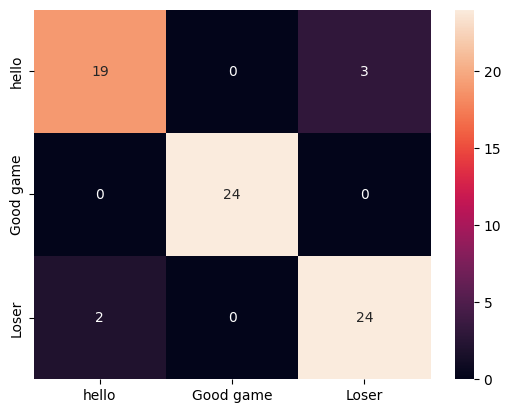

In [88]:
cm = confusion_matrix(ytrue, yhat)
sns.heatmap(cm, annot=True, xticklabels=actions, yticklabels=actions)
plt.show()

In [89]:
print("Training accuracy:", accuracy_score(ytrue, yhat))

Training accuracy: 0.9305555555555556


## 11. Test in Real Time

In [90]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame

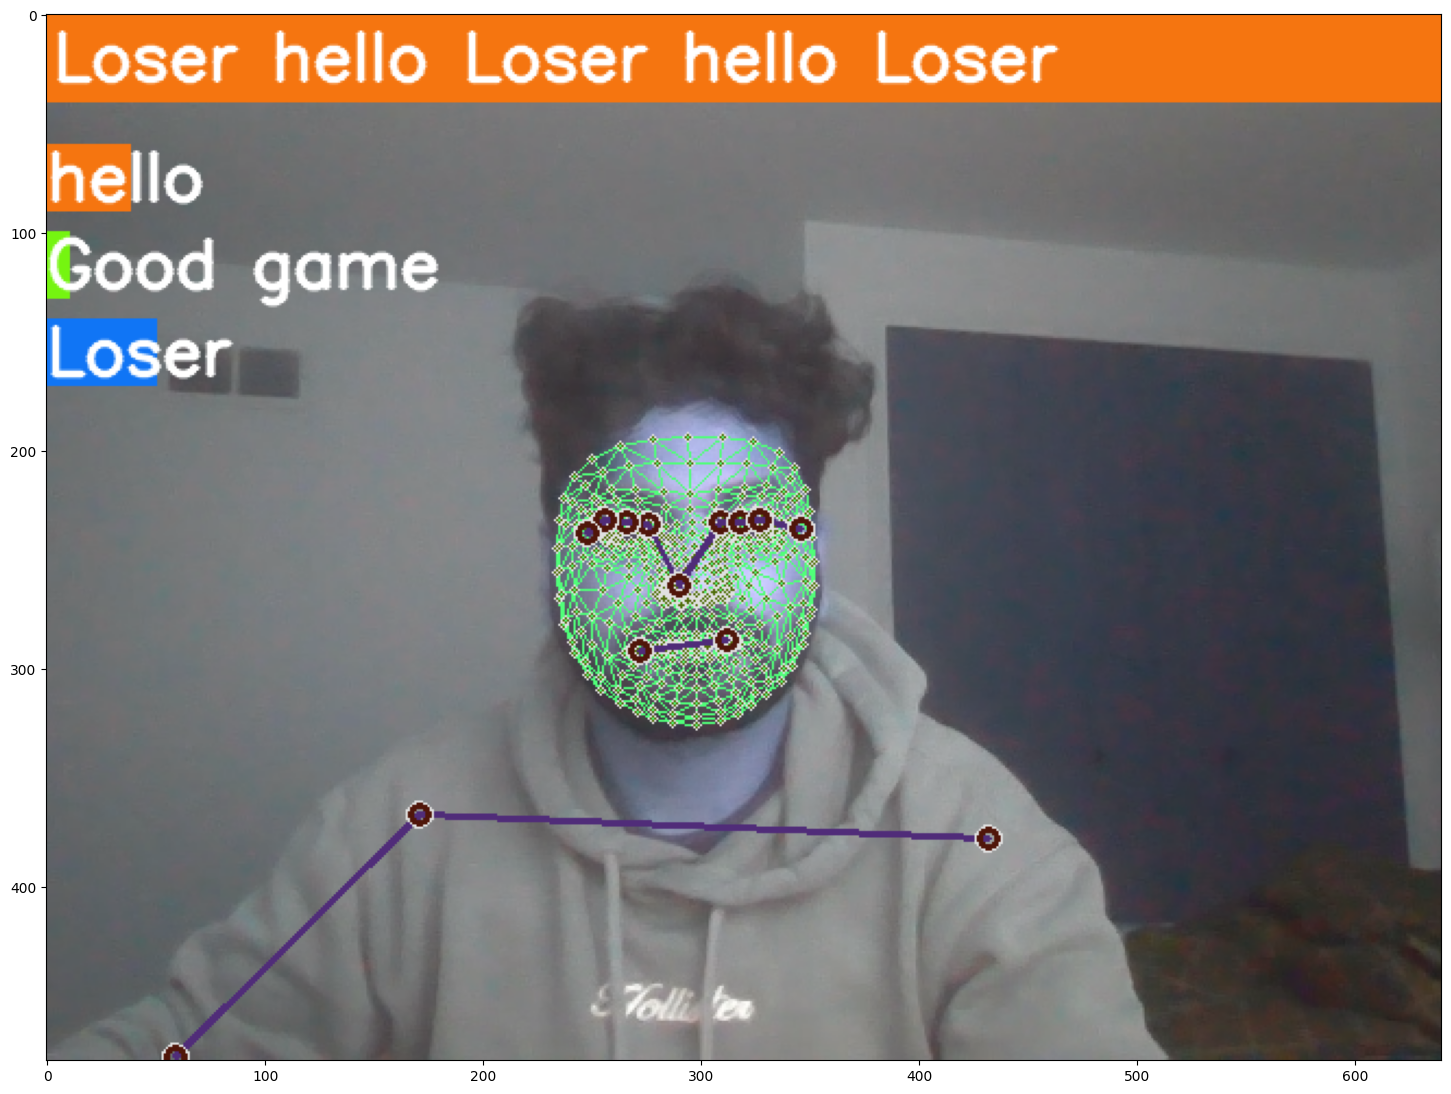

In [92]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [91]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame.")
            break

        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)

        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print("Predicted action:", actions[np.argmax(res)])
            predictions.append(np.argmax(res))

            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            image = prob_viz(res, actions, image, colors)

        cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 16ms/step
Predicted action: Loser
1/1 [==============================] - 0s 10ms/step
Predicted action: Loser
1/1 [==============================] - 0s 23ms/step
Predicted action: Loser
1/1 [==============================] - 0s 25ms/step
Predicted action: Loser
1/1 [==============================] - 0s 20ms/step
Predicted action: hello
1/1 [==============================] - 0s 16ms/step
Predicted action: hello
1/1 [==============================] - 0s 26ms/step
Predicted action: hello
1/1 [==============================] - 0s 20ms/step
Predicted action: hello
1/1 [==============================] - 0s 16ms/step
Predicted action: hello
1/1 [==============================] - 0s 12ms/step
Predicted action: hello
1/1 [==============================] - 0s 23ms/step
Predicted action: hello
1/1 [==============================] - 0s 16ms/step
Predicted action: Loser
1/1 [==============================] - 0s 18ms/step
Predicted action: Loser
1/1 [=======

1/1 [==============================] - 0s 48ms/step
Predicted action: Good game
1/1 [==============================] - 0s 43ms/step
Predicted action: Good game
1/1 [==============================] - 0s 55ms/step
Predicted action: Good game
1/1 [==============================] - 0s 16ms/step
Predicted action: Good game
1/1 [==============================] - 0s 16ms/step
Predicted action: Good game
1/1 [==============================] - 0s 17ms/step
Predicted action: Good game
1/1 [==============================] - 0s 27ms/step
Predicted action: Good game
1/1 [==============================] - 0s 16ms/step
Predicted action: Loser
1/1 [==============================] - 0s 14ms/step
Predicted action: Loser
1/1 [==============================] - 0s 15ms/step
Predicted action: Loser
1/1 [==============================] - 0s 14ms/step
Predicted action: Loser
1/1 [==============================] - 0s 13ms/step
Predicted action: Loser
1/1 [==============================] - 0s 19ms/step
Predicte

Predicted action: Loser
1/1 [==============================] - 0s 23ms/step
Predicted action: Loser
1/1 [==============================] - 0s 6ms/step
Predicted action: Loser
1/1 [==============================] - 0s 12ms/step
Predicted action: Loser
1/1 [==============================] - 0s 16ms/step
Predicted action: Loser
1/1 [==============================] - 0s 23ms/step
Predicted action: hello
1/1 [==============================] - 0s 27ms/step
Predicted action: hello
1/1 [==============================] - 0s 16ms/step
Predicted action: hello
1/1 [==============================] - 0s 16ms/step
Predicted action: hello
1/1 [==============================] - 0s 11ms/step
Predicted action: hello
1/1 [==============================] - 0s 20ms/step
Predicted action: hello
1/1 [==============================] - 0s 20ms/step
Predicted action: hello
1/1 [==============================] - 0s 16ms/step
Predicted action: hello
1/1 [==============================] - 0s 20ms/step
Predicted act

1/1 [==============================] - 0s 16ms/step
Predicted action: Loser
1/1 [==============================] - 0s 41ms/step
Predicted action: Loser
1/1 [==============================] - 0s 16ms/step
Predicted action: Loser
1/1 [==============================] - 0s 16ms/step
Predicted action: Loser
1/1 [==============================] - 0s 16ms/step
Predicted action: Loser
1/1 [==============================] - 0s 16ms/step
Predicted action: Loser
1/1 [==============================] - 0s 16ms/step
Predicted action: Loser
1/1 [==============================] - 0s 26ms/step
Predicted action: Loser
1/1 [==============================] - 0s 19ms/step
Predicted action: Loser
1/1 [==============================] - 0s 10ms/step
Predicted action: Loser
1/1 [==============================] - 0s 16ms/step
Predicted action: Loser
1/1 [==============================] - 0s 22ms/step
Predicted action: Loser
1/1 [==============================] - 0s 25ms/step
Predicted action: Loser
1/1 [=======